In [7]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image, ImageDraw, ImageFont 
import requests
import copy
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches



%matplotlib inline

## Import dataset

In [1]:
import torchvision
from torchvision import transforms

# Define the path to the COCO dataset
data_dir = '../datasets/label_studio_gen/coco_dataset/images'
annFile = '../datasets/label_studio_gen/coco_dataset/result.json'

# Define the transformations to be applied to the images
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create the COCO dataset
coco_dataset = torchvision.datasets.CocoDetection(root=data_dir, annFile=annFile, transform=transform)
class_labels = [cat['name'] for cat in coco_dataset.coco.cats.values()]
print(class_labels)


/Users/sarathmenon/llm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
['barrel', 'bird', 'book', 'box', 'bush', 'chair', 'coin', 'crate', 'door', 'globe', 'hat', 'instrument', 'lamp', 'mirror', 'moon', 'painting', 'pillar', 'pillow', 'skull', 'sphere', 'stick', 'sword', 'table', 'telescope', 'treasure', 'tree', 'vase', 'window']


### Plot ground truth segmentation

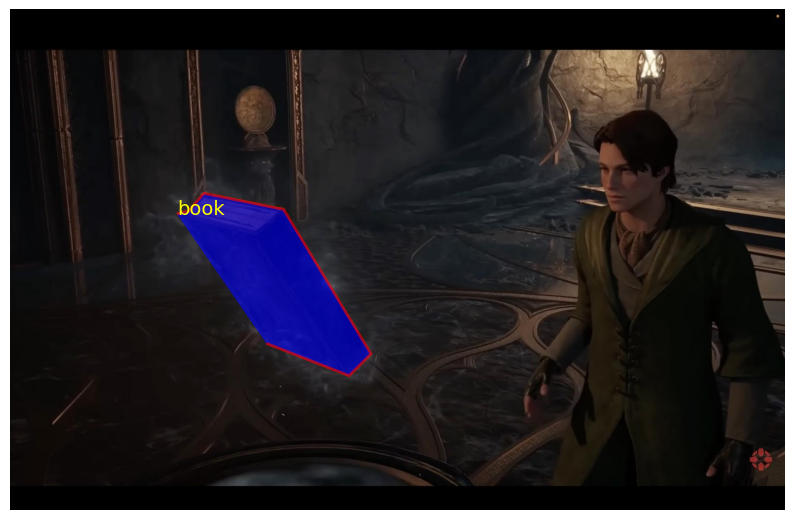

In [113]:
from matplotlib.path import Path
import matplotlib.patches as patches
import torch


def show(image, annotations, click_point=None):
    """
    Plots an image from the COCO dataset along with its segmentation map.

    Args:
    image (PIL Image): The image to plot.
    annotations (list):z A list of annotations, where each annotation is a dictionary containing 'segmentation' and other keys.
    """

    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0)  # Transpose the image tensor

    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    ax = plt.gca()

    for annotation in annotations:
        # plot class label
        class_label = class_labels[annotation['category_id']]

        class_label_x = annotation['segmentation'][0][0]
        class_label_y = annotation['segmentation'][0][1] 
        plt.text(class_label_x, class_label_y, class_label, fontsize=14, color='yellow')

        # plot segmentation map
        for segmentation in annotation['segmentation']:
            poly = np.array(segmentation).reshape((len(segmentation) // 2, 2))
            poly_path = Path(poly)
            patch = patches.PathPatch(poly_path, facecolor='blue', edgecolor='red', linewidth=2, alpha=0.6)
            ax.add_patch(patch)

    if click_point:
        for point in click_point:
            plt.plot(point['x'], point['y'], '*', color='yellow', markersize=10)
    plt.axis('off')
    plt.grid(False)
    plt.show()

# Example usage:
index = 11
img, ground_truth_annotations = coco_dataset[index]
show(img, ground_truth_annotations)

## Instantiate model

In [10]:
model_id = 'microsoft/Florence-2-large-ft'
images_path = "../datasets/raw_media/gameplay_images"

from transformers.dynamic_module_utils import get_imports
from unittest.mock import patch

def fixed_get_imports(filename: str | os.PathLike) -> list[str]:
    """Work around for https://huggingface.co/microsoft/phi-1_5/discussions/72."""
    if not str(filename).endswith("/modeling_florence2.py"):
        return get_imports(filename)
    imports = get_imports(filename)
    imports.remove("flash_attn")
    return imports


with patch("transformers.dynamic_module_utils.get_imports", fixed_get_imports):
        model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True)
        processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True)

In [11]:
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']

def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')


    # Show the plot
    plt.show()

def convert_to_od_format(data):  
    """  
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.  
  
    Parameters:  
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.  
  
    Returns:  
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.  
    """  
    # Extract bounding boxes and labels  
    bboxes = data.get('bboxes', [])  
    labels = data.get('bboxes_labels', [])  
      
    # Construct the output format  
    od_results = {  
        'bboxes': bboxes,  
        'labels': labels  
    }  
      
    return od_results  

def draw_ocr_bboxes(image, prediction):
    scale = 1
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",
        
                    fill=color)
    display(image)

## Inference

text input: instrument.
[{'x': 934.8480224609375, 'y': 360.2324981689453, 'label': 'instrument'}]
Point lies inside the polygon: True


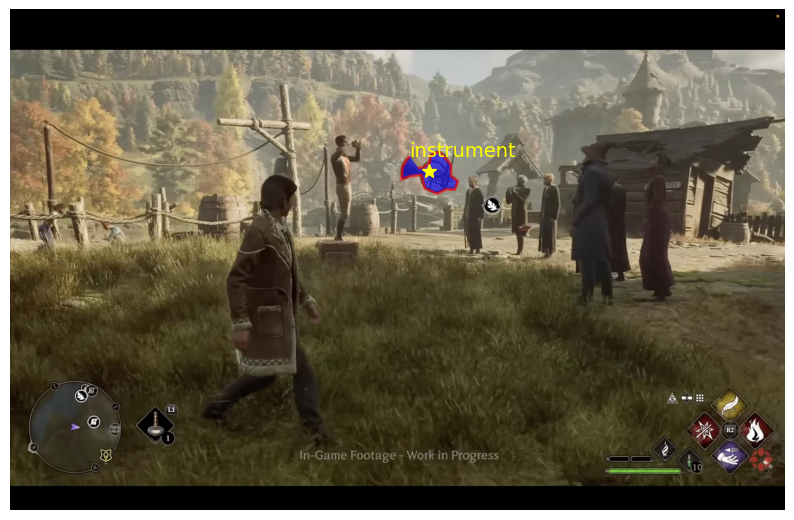

In [126]:
from torchvision import transforms

index = 5
image, annotations = coco_dataset[index]

# create text input from labels
labels = [class_labels[annotation['category_id']] for annotation in annotations]
text_input = ""
for label in labels:
    text_input += label + "."
print(f"text input: {text_input}")

# convert pytorch tensor to PIL image
to_pil = transforms.ToPILImage()
image = to_pil(image.mul(255).byte())

task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input=text_input)
# print(results)
# plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

click_points = get_click_point(results['<CAPTION_TO_PHRASE_GROUNDING>'])
print(click_points)

for (annotation, label) in zip(annotations, labels):
    is_inside, poly_path = check_point_in_polygon(annotation, click_points[0])
    print(f"Point lies inside the polygon: {is_inside}")

show(image, annotations, click_point=click_points)

### Check if predicted click point lies within the bounding boxes

[{'x': 934.8480224609375, 'y': 360.2324981689453, 'label': 'instrument'}]
Point lies inside the polygon: True


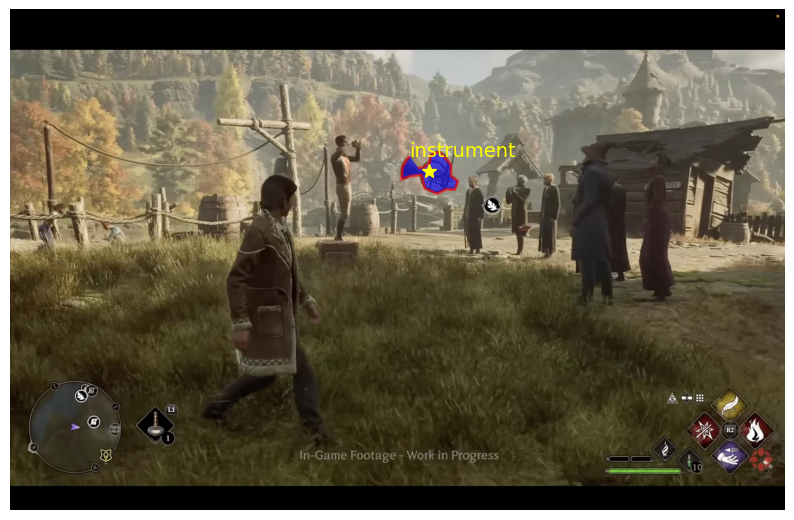

In [125]:
def get_click_point(data):
    click_points = []
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox

        # get geometric center of the bounding box
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        click_points.append({'x': center_x, 'y': center_y, 'label': label})

    return click_points

def check_point_in_polygon(annotation, point):
    point = (point['x'], point['y'])
    for segmentation in annotation['segmentation']:
        poly = np.array(segmentation).reshape((len(segmentation) // 2, 2))
        poly_path = Path(poly)
    
    return poly_path.contains_point(point) , poly_path